In [1]:
import math
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import scikitplot
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Define data directories
data_dir = '/Users/mkopczynski/Desktop/engineer-diploma/model/data/Dataset_emotions/'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

# Define image size
img_width = 48
img_height = 48

# Function to load and preprocess images
def load_and_preprocess_images(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    num_classes = len(class_names)

    # Create a mapping dictionary to remember class names
    class_name_mapping = {i: class_name for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if class_name == '.DS_Store':  # Skip system files like .DS_Store on macOS
            continue
        for filename in os.listdir(class_dir):
            if filename.endswith('.DS_Store'):  # Skip system files like .DS_Store
                continue
            img = load_img(os.path.join(class_dir, filename), target_size=(img_width, img_height))
            img = img_to_array(img)
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(class_name)  # Use class name as label

    return np.array(images), np.array(labels), class_name_mapping

# Load and preprocess training and validation data
X_train, y_train, train_class_name_mapping = load_and_preprocess_images(train_dir)
X_valid, y_valid, valid_class_name_mapping = load_and_preprocess_images(valid_dir)

# Convert labels to one-hot encoding
class_names = np.unique(y_train)
num_classes = len(class_names)

label_mapping = {class_name: i for i, class_name in enumerate(class_names)}

y_train = np.array([label_mapping[class_name] for class_name in y_train])
y_valid = np.array([label_mapping[class_name] for class_name in y_valid])

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


In [3]:
#MODEL
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [4]:
#Parameters

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

batch_size = 32 #batch size of 32 performs the best.

epochs = 100

optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),
    
  optimizers.Adam(0.001),
]

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [5]:
 #Training

model = build_net(optims[1]) 

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

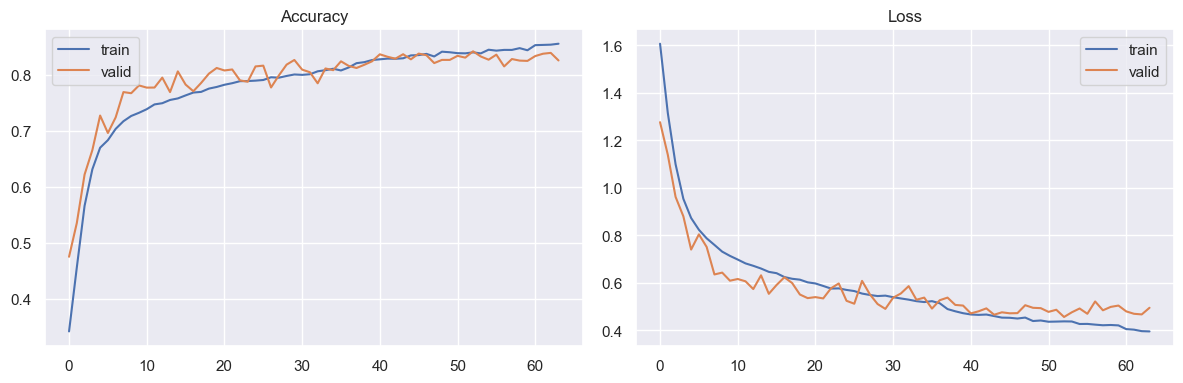

In [6]:
#plot the training and validation metrics

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')

pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')

pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

247/247 [==============================] - 18s 71ms/step
total wrong validation predictions: 1250


              precision    recall  f1-score      support
0              0.701299  0.788897  0.742523  1369.000000
1              0.818966  0.616883  0.703704   462.000000
2              0.953086  0.850220  0.898719  2270.000000
3              0.804969  0.876861  0.839378  2217.000000
4              0.897452  0.891772  0.894603  1580.000000
accuracy       0.841732  0.841732  0.841732     0.841732
macro avg      0.835154  0.804927  0.815786  7898.000000
weighted avg   0.848890  0.841732  0.842757  7898.000000


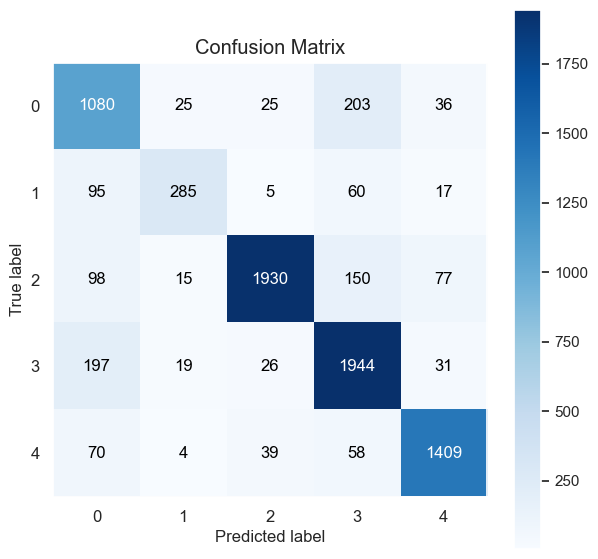

In [8]:
#visualize a confusion-matrix

yhat_valid_probs = model.predict(X_valid)
yhat_valid = np.argmax(yhat_valid_probs, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

# Calculate total wrong validation predictions
total_wrong_predictions = np.sum(np.argmax(y_valid, axis=1) != yhat_valid)
print(f'total wrong validation predictions: {total_wrong_predictions}\n\n')

# Generate the classification report
classification_rep = classification_report(np.argmax(y_valid, axis=1), yhat_valid, output_dict=True)

# Convert the classification report to a DataFrame
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Save the classification report to a CSV file
classification_rep_df.to_csv("classification_report.csv")

# Print the classification report to the console
print(classification_rep_df)

In [9]:
model.save('fer.h5')

/Users/mkopczynski/mambaforge/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
